# Importação e preparação dos dados

In [1]:
import pandas as pd

df = pd.read_csv('../dados/excertos_filtrados500.csv', sep = '|')
df.head()

,COD,DESCR_AREA,filtrado
0,1400,Responsabilidade,voto cuidar auto tomada conta especial instaur...
1,1700,Finanças Públicas,voto cuidar auto solicitação congresso naciona...
2,5700,Responsabilidade,relatório tratar embargo declaração opor exemp...
3,284,Direito Processual,voto relação outro processo judiciais tratar r...
4,298,Pessoal,voto relativo ato envolver senhor caber rememo...


In [2]:
df.shape

(13285, 3)

In [3]:
from sklearn.preprocessing import LabelBinarizer

areas = df.groupby(['DESCR_AREA']).groups.keys()
lbArea = LabelBinarizer()
lbArea.fit([x for x in areas])
y = lbArea.transform(df['DESCR_AREA'])
y.shape

(13285, 10)

In [4]:
from keras.preprocessing.text import Tokenizer
import numpy as np

vocabulario = 30000
limite_texto = 500
dim_vetor = 100

tokenizer = Tokenizer(num_words=vocabulario)
tokenizer.fit_on_texts(df['filtrado'].astype(str))

sequences = tokenizer.texts_to_sequences(df['filtrado'].astype(str))

word_index = tokenizer.word_index
vocabulario = len(word_index) + 1
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 22972 unique tokens.


In [5]:
max = 0
lens = []
for seq in sequences:
    lens.append(len(seq))
np.min(lens), np.mean(lens), np.max(lens), np.std(lens), len(lens), sum(pd.Series(lens) > limite_texto), sum(pd.Series(lens) > limite_texto)/len(lens)

(12,
 269.96507339104255,
 509,
 142.93907674539003,
 13285,
 19,
 0.0014301844185171245)

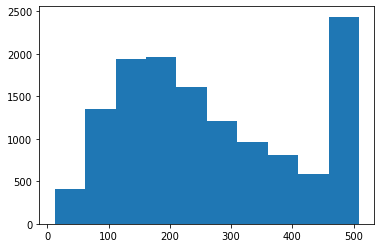

In [7]:
import matplotlib.pyplot as plt
plt.hist(lens)
plt.show()

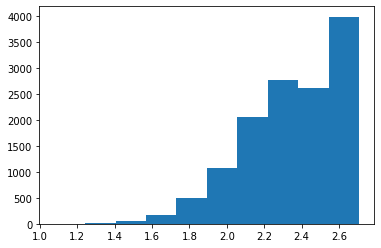

In [8]:
plt.hist(np.log10(lens))
plt.show()

In [9]:
np.percentile(lens, 25), np.percentile(lens, 50), np.percentile(lens, 75), np.percentile(lens, 90), np.percentile(lens, 95)

(152.0, 240.0, 387.0, 500.0, 500.0)

In [10]:
np.mean(np.log10(lens)), 10**np.mean(np.log10(lens)), np.std(np.log10(lens)), (np.mean(np.log10(lens)) + 2*np.std(np.log10(lens))), 10**(np.mean(np.log10(lens)) + 2*np.std(np.log10(lens)))

(2.358246697195892,
 228.16377684126218,
 0.2698266994442811,
 2.897900096084454,
 790.4967633680508)

In [11]:
from keras.preprocessing.sequence import pad_sequences

x = pad_sequences(sequences, maxlen=limite_texto)

print('Shape of data tensor:', x.shape)

Shape of data tensor: (13285, 500)


In [12]:
x.shape, y.shape

((13285, 500), (13285, 10))

# Treinamento

In [18]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

W1121 07:08:02.543875 139979849807680 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1121 07:08:02.642590 139979849807680 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1121 07:08:02.644637 139979849807680 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1121 07:08:02.672413 139979849807680 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          2297300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              102402048 
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total para

In [19]:
history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1121 07:08:10.973312 139979849807680 deprecation.py:323] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 46s 4ms/step - loss: 1.2057 - categorical_accuracy: 0.5923 - val_loss: 1.3208 - val_categorical_accuracy: 0.5687
Epoch 2/20
10628/10628 [==============================] - 40s 4ms/step - loss: 0.4248 - categorical_accuracy: 0.8739 - val_loss: 1.1662 - val_categorical_accuracy: 0.6628
Epoch 3/20
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0991 - categorical_accuracy: 0.9794 - val_loss: 1.3808 - val_categorical_accuracy: 0.6970
Epoch 4/20
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0689 - categorical_accuracy: 0.9928 - val_loss: 1.4814 - val_categorical_accuracy: 0.7117
Epoch 5/20
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0595 - categorical_accuracy: 0.9944 - val_loss: 1.6122 - val_categorical_accuracy: 0.7098
Epoch 6/20
10628/10628 [==============================] - 41s 4ms/step - loss: 0.0633 - categori

In [20]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])
model.summary()

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          2297300   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              102402048 
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                10250     
Total para

In [13]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from keras.layers.core import Dropout

model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

W1121 08:17:46.472817 140551704823616 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1121 08:17:46.766660 140551704823616 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1121 08:17:46.795849 140551704823616 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1121 08:17:46.845992 140551704823616 deprecation_wrapper.py:119] From /home/leonardo/anaconda3/envs/gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is d

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 57s 5ms/step - loss: 1.2095 - categorical_accuracy: 0.5870 - val_loss: 1.2284 - val_categorical_accuracy: 0.5529
Epoch 2/20
10628/10628 [==============================] - 42s 4ms/step - loss: 0.3717 - categorical_accuracy: 0.8895 - val_loss: 1.1313 - val_categorical_accuracy: 0.6714
Epoch 3/20
10628/10628 [==============================] - 42s 4ms/step - loss: 0.0702 - categorical_accuracy: 0.9891 - val_loss: 1.3598 - val_categorical_accuracy: 0.6978
Epoch 4/20
10628/10628 [==============================] - 42s 4ms/step - loss: 0.0529 - categorical_accuracy: 0.9935 - val_loss: 1.4230 - val_categorical_accuracy: 0.6989
Epoch 5/20
10628/10628 [==============================] - 42s 4ms/step - loss: 0.0405 - categorical_accuracy: 0.9947 - val_loss: 1.4418 - val_categorical_accuracy: 0.6959
Epoch 6/20
10628/10628 [==============================] - 42s 4ms/step - loss: 0.0373 - categori

In [14]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 24s 2ms/step - loss: 1.2178 - categorical_accuracy: 0.5838 - val_loss: 0.9918 - val_categorical_accuracy: 0.6899
Epoch 2/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.4143 - categorical_accuracy: 0.8741 - val_loss: 1.0777 - val_categorical_accuracy: 0.6850
Epoch 3/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0811 - categorical_accuracy: 0.9855 - val_loss: 1.3140 - val_categorical_accuracy: 0.6970
Epoch 4/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0579 - categorical_accuracy: 0.9937 - val_loss: 1.4560 - val_categorical_accuracy: 0.6872
Epoch 5/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0503 - categorical_accuracy: 0.9944 - val_loss: 1.4681 - val_categorical_accuracy: 0.6921
Epoch 6/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0412 - categori

In [15]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 23s 2ms/step - loss: 1.2540 - categorical_accuracy: 0.5739 - val_loss: 1.2261 - val_categorical_accuracy: 0.5743
Epoch 2/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.4316 - categorical_accuracy: 0.8691 - val_loss: 1.0657 - val_categorical_accuracy: 0.7015
Epoch 3/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0921 - categorical_accuracy: 0.9814 - val_loss: 1.3899 - val_categorical_accuracy: 0.6948
Epoch 4/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0483 - categorical_accuracy: 0.9939 - val_loss: 1.4154 - val_categorical_accuracy: 0.6970
Epoch 5/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0392 - categorical_accuracy: 0.9944 - val_loss: 1.4939 - val_categorical_accuracy: 0.7106
Epoch 6/20
10628/10628 [==============================] - 22s 2ms/step - loss: 0.0388 - categori

In [16]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 13s 1ms/step - loss: 1.2655 - categorical_accuracy: 0.5689 - val_loss: 0.9818 - val_categorical_accuracy: 0.6850
Epoch 2/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.4720 - categorical_accuracy: 0.8557 - val_loss: 1.1743 - val_categorical_accuracy: 0.6466
Epoch 3/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.1068 - categorical_accuracy: 0.9766 - val_loss: 1.3373 - val_categorical_accuracy: 0.6711
Epoch 4/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.0517 - categorical_accuracy: 0.9922 - val_loss: 1.4269 - val_categorical_accuracy: 0.7012
Epoch 5/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.0433 - categorical_accuracy: 0.9944 - val_loss: 1.4721 - val_categorical_accuracy: 0.7012
Epoch 6/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.0403 - categori

In [17]:
model = Sequential()
model.add(Embedding(vocabulario, dim_vetor, input_length=x.shape[1]))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta',  metrics=["categorical_accuracy"])

history = model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2, verbose=1, shuffle=True)

Train on 10628 samples, validate on 2657 samples
Epoch 1/20
10628/10628 [==============================] - 13s 1ms/step - loss: 1.2829 - categorical_accuracy: 0.5578 - val_loss: 1.0164 - val_categorical_accuracy: 0.6628
Epoch 2/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.4816 - categorical_accuracy: 0.8555 - val_loss: 1.0343 - val_categorical_accuracy: 0.6820
Epoch 3/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.1278 - categorical_accuracy: 0.9684 - val_loss: 1.2562 - val_categorical_accuracy: 0.6887
Epoch 4/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.0608 - categorical_accuracy: 0.9903 - val_loss: 1.4355 - val_categorical_accuracy: 0.6985
Epoch 5/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.0453 - categorical_accuracy: 0.9935 - val_loss: 1.5223 - val_categorical_accuracy: 0.7012
Epoch 6/20
10628/10628 [==============================] - 12s 1ms/step - loss: 0.0400 - categori